In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
#from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Deconvolution2D, Input, merge
from keras.layers.core import Flatten
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model
import numpy as np
import sys, glob
import cv2
import os
import argparse
from sklearn.feature_extraction.image import extract_patches_2d

def load_image(path):
    img = cv2.imread(path, 1)
    #img = np.float32(cv2.resize(img, (32, 32))) / 127.5 - 1
    #img = np.float32(img) / 127.5 - 1
    img = np.rollaxis(np.float32(img), 2, 0)
    return img
  
def get_batches(paths_a, batch_size):
    for i in range(len(paths_a)/batch_size):
        yield i, [load_image(path) for path in paths_a[i*batch_size : (i + 1) * batch_size]]

def get_new_batch(path_input, resize_size = 1.):   
    paths = glob.glob(os.path.join(path_input, "*.png"))
    all_patches = []
    print paths
    from scipy.misc import imresize
    for index, image_batch_a in get_batches(paths, batch_size=1):
        #print index
        #print(image_batch_a[0].shape)
        current_im = image_batch_a[0]
        #if resize_size<1:
        #    current_im = extract_patches_2d(current_im,(512,512))
        #current_im = current_im[:,::4,::4]
        #current_im = imresize(image_batch_a[0], resize_size, interp='nearest')

        #current_im = np.rollaxis(np.float32(current_im), 2, 0)
        current_im  = np.expand_dims(current_im, axis = 0)
        all_patches.append(current_im)
    X_H = np.concatenate(all_patches)

    return X_H


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


In [2]:
X_A = get_new_batch('D:\street_data\segmentation', 0.25)
X_B = get_new_batch('D:\street_data\\flowx', 0.25)
X_C = get_new_batch('D:\street_data\\flowy', 0.25)
X_D = get_new_batch('D:\street_data\\raw', 0.25)
X = np.concatenate((X_A,X_B,X_C,X_D), axis = 1)

Y_train = X_A[0::2,:,::4,::4]
#X_test = X[1::2,:,::2,::2]
X_train = X[1::2,:,::4,::4]
#Y_test = X_A[1::2,:,:,:]

['D:\\street_data\\segmentation\\10_test_.png', 'D:\\street_data\\segmentation\\10_train_.png', 'D:\\street_data\\segmentation\\11_test_.png', 'D:\\street_data\\segmentation\\11_train_.png', 'D:\\street_data\\segmentation\\12_test_.png', 'D:\\street_data\\segmentation\\12_train_.png', 'D:\\street_data\\segmentation\\13_test_.png', 'D:\\street_data\\segmentation\\13_train_.png', 'D:\\street_data\\segmentation\\14_test_.png', 'D:\\street_data\\segmentation\\14_train_.png', 'D:\\street_data\\segmentation\\15_test_.png', 'D:\\street_data\\segmentation\\15_train_.png', 'D:\\street_data\\segmentation\\16_test_.png', 'D:\\street_data\\segmentation\\16_train_.png', 'D:\\street_data\\segmentation\\17_test_.png', 'D:\\street_data\\segmentation\\17_train_.png', 'D:\\street_data\\segmentation\\18_test_.png', 'D:\\street_data\\segmentation\\18_train_.png', 'D:\\street_data\\segmentation\\19_test_.png', 'D:\\street_data\\segmentation\\19_train_.png', 'D:\\street_data\\segmentation\\1_test_.png', 'D:

In [3]:
import theano.tensor as T
from keras import backend as K
from keras.engine.topology import Layer
class PixelLayer(Layer):
    def __init__(self, **kwargs):
        super(PixelLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, input, mask=None):
        (bs, cc, h, w) = input.shape
        tmp = input.transpose((0,2,3,1))
        tmp = tmp.reshape((bs*h*w, cc))
        tmp = T.nnet.nnet.softmax(tmp)
        output = tmp.reshape((bs, h, w, cc))
        output = output.transpose((0,3,1,2))
        return output

    def get_output_shape_for(self, shape):
        return (shape[0], shape[1], shape[2], shape[3])
    

filter_set = [64,32]
#init = Dropout(0.25)(init)
inita = Input(shape=(12,256,256))
init = inita
#initd = Dropout(0.25)(init)
n_layers = len(filter_set)
cs = []
for i in range(n_layers-1):
    #init = Dropout(0.1)(init)
    
    init = Convolution2D(filter_set[i], 3, 3, activation='relu', border_mode='same')(init)
init = Convolution2D(filter_set[i+1], 3, 3, activation='relu', border_mode='same')(init)


decoded = Convolution2D(3, 5, 5, activation='linear', border_mode='same')(init)
#decoded = BatchNormalization(mode=2, axis=1)(decoded)
#decoded = PixelLayer()(decoded)
# decoded = Convolution2D(1, 5, 5, activation='linear', border_mode='same')(c1)
import keras
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
er = keras.callbacks.ModelCheckpoint('segcheck', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only = True)
full_model = Model(input=inita, output=decoded)
full_model.compile(loss='mse',
        optimizer='Nadam')
full_model.summary()

#for epoch in range(50):
errors = []
# for i in range(15):
  #print np.concatenate(image_batch_b).shape
#train_inds = range(0,X_H.shape[0])
#test_inds = range(7,8)
#X_G = np.expand_dims(X_G, axis = 1)

from keras.models import load_model

#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one


full_model.fit(X_train / 255., Y_train / 255., batch_size = 1, nb_epoch = 256, validation_split = 0.15, callbacks = [es, er])
#full_model.load_weights('segcheck')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 12, 256, 256)  0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 256, 256)  3488        input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 256, 256)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 32, 256, 256)  9248        convolution2d_2[0][0]            
___________________________________________________________________________________________

In [6]:
full_model.load_weights('segcheck')
results = full_model.predict(X_train / 255. , batch_size = 1)

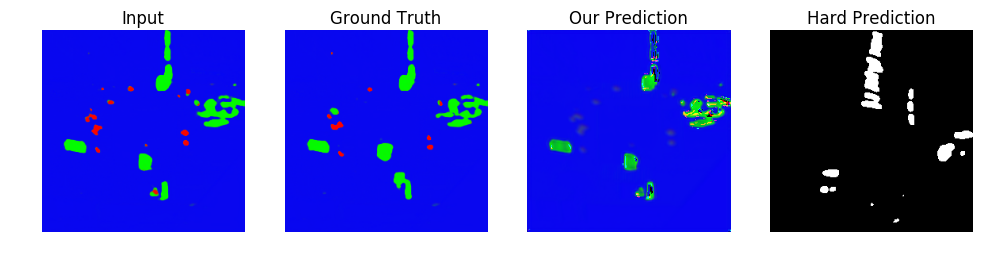

In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  


img_idx = 0
#import PyQt4
class_results = np.argmax(results, axis = 1)
#%matplotlib notebook
resultsa = 1. * (results > 0.5)
fig = plt.figure(figsize=(12, 12))
for j in range(1):
    a=fig.add_subplot(3,4,1+j*4)
    plt.imshow(np.transpose(X_train[30,0:3,:,:],(1,2,0))[:,:,(2,1,0)] / 255.)
    a.set_title('Input')
    plt.axis('off')
    a=fig.add_subplot(3,4,2+j*4)
    plt.imshow(np.transpose(Y_train[30,:,:,:],(1,2,0))[:,:,(2,1,0)] / 255.)
    a.set_title('Ground Truth')
    plt.axis('off')
    a=fig.add_subplot(3,4,3+j*4)
    plt.imshow(np.transpose(results[30],(1,2,0))[:,:,(2,1,0)])
    a.set_title('Our Prediction')
    plt.axis('off')
    a=fig.add_subplot(3,4,4+j*4)
    plt.imshow(np.transpose(class_results[-2],(0,1)), cmap= plt.get_cmap('gray'))
    a.set_title('Hard Prediction')
    plt.axis('off')
    cv2.imwrite('input_' + str(j) + '.png',   (np.transpose(X_A[-5],(1,2,0))[:,:,(2,1,0)]))
    cv2.imwrite('pr_ground_truth_' + str(j) + '.png', (np.transpose(X_A[-4],(1,2,0))[:,:,(2,1,0)] ))
    cv2.imwrite('pr_soft_predictions_' + str(j) + '.png', 255. * (np.transpose(results[0],(1,2,0))[:,:,(2,1,0)]))
    cv2.imwrite('pr_hard_predictions_' + str(j) + '.png', 127.5 * (np.transpose(class_results[0],(0,1))))

In [7]:
X_A.shape

(116L, 3L, 1024L, 1024L)

In [10]:
len(paths)

116

In [3]:

X_test = X_H[test_inds]
Y_test = X_G[test_inds]

results = full_model.predict(X_test / 255. , batch_size = 1)

#results = np.minimum(np.maximum(1.,results), 3.)

#results = np.round(results)

In [4]:
class_results = np.argmax(results, axis = 1)

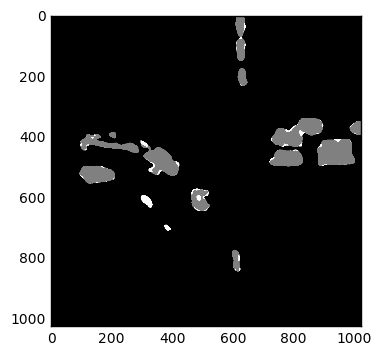

In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

plt.imshow(np.transpose(class_results[0],(0,1)), cmap= plt.get_cmap('gray'))

(1024L, 1024L)

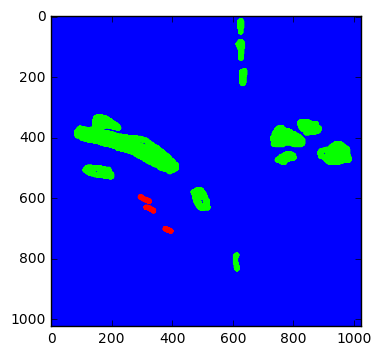

In [24]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

plt.imshow(np.transpose(X_G[test_inds[0]] / 255.,(1,2,0))[:,:,(2,1,0)])

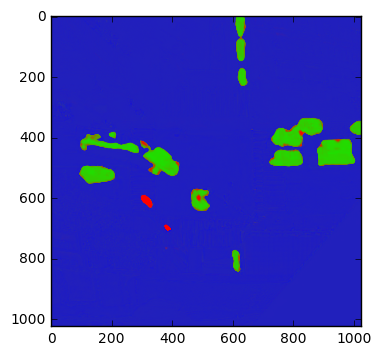

In [25]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

plt.imshow(np.transpose(results[0],(1,2,0))[:,:,(2,1,0)])

In [30]:
results[0]

array([[[ 0.74740124,  0.74905461,  0.74401265, ...,  0.7533657 ,
          0.71549946,  0.7278958 ],
        [ 0.74352175,  0.75986403,  0.74114525, ...,  0.74645615,
          0.72906059,  0.72046202],
        [ 0.73944128,  0.77558064,  0.75470644, ...,  0.74104565,
          0.75341183,  0.7664457 ],
        ..., 
        [ 0.75617087,  0.75194538,  0.76288021, ...,  0.73702747,
          0.74794662,  0.73182791],
        [ 0.7442801 ,  0.75515789,  0.75415683, ...,  0.74028659,
          0.73731494,  0.72646689],
        [ 0.71382266,  0.74974221,  0.76040602, ...,  0.72422773,
          0.73960382,  0.71898073]],

       [[ 0.12500158,  0.12833491,  0.12512194, ...,  0.12288586,
          0.14361396,  0.13703355],
        [ 0.122807  ,  0.11734691,  0.12786147, ...,  0.12627976,
          0.13222565,  0.1447804 ],
        [ 0.13251854,  0.11568855,  0.1190389 , ...,  0.1311824 ,
          0.12518628,  0.12085804],
        ..., 
        [ 0.11791307,  0.12570205,  0.11553829, ...,

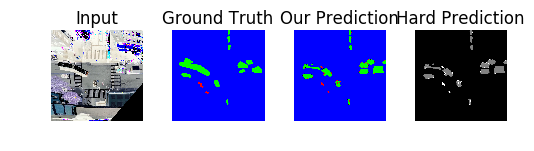

In [33]:
np.max(results)

1.0

In [ ]:
X_H[test_inds[img_idx]].shape

In [6]:
# a = {}
a['X_G'] = X_G_new
a['X_H'] = X_H

import scipy.io as io
io.savemat('inputs',a)

NameError: name 'a' is not defined

In [ ]:
np.max(X_G_new[test_inds[0]])

In [11]:
results[0]

array([[[ 0.42607045,  0.18073364,  0.21571714, ...,  0.19561785,
          0.06287246,  0.06006673],
        [ 0.3353602 ,  0.05808589,  0.04205862, ...,  0.04923126,
          0.00688615,  0.01287175],
        [ 0.33859664,  0.06782316,  0.03317761, ...,  0.0561432 ,
          0.00714742,  0.01342029],
        ..., 
        [ 0.72378153,  0.92703378,  0.98068321, ...,  0.58781523,
          0.21238849,  0.19849704],
        [ 0.63417518,  0.84789246,  0.92284238, ...,  0.44368595,
          0.27236748,  0.29914653],
        [ 0.4749077 ,  0.6837275 ,  0.74989587, ...,  0.52685732,
          0.47789398,  0.45546013]],

       [[ 0.05436953,  0.04093829,  0.0163824 , ...,  0.03517216,
          0.07313983,  0.14198563],
        [ 0.025825  ,  0.01391878,  0.00526601, ...,  0.01974343,
          0.04236996,  0.115522  ],
        [ 0.01998518,  0.01042264,  0.0036673 , ...,  0.01399764,
          0.03374561,  0.07031066],
        ..., 
        [ 0.08056484,  0.03474475,  0.01500662, ...,

In [12]:
X_G_new[test_inds[0]]

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  0.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [8]:
X_G_new[test_inds[0]].shape

(3L, 512L, 512L)

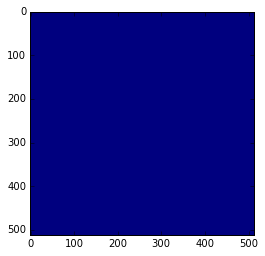

In [9]:

plt.imshow(results[1,0]/ 3.)

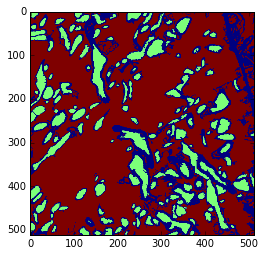

In [10]:
plt.imshow(X_G[1,0] / 3.)

In [11]:
results[1,0].shape

(512L, 512L)

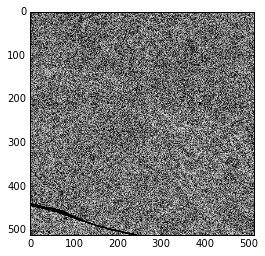

In [12]:
plt.imshow(np.transpose(X_H[1],(2,1,0)) / 3.)

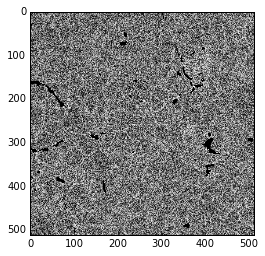

In [13]:
train_inds = range(0,20)
test_inds = range(20,30)
plt.imshow(np.transpose(X_test[1]/3.,(1,2,0)))

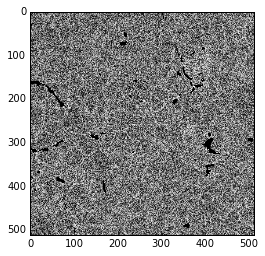

In [14]:
plt.imshow(np.transpose(X_H[21],(1,2,0)) / 3.)